In [691]:
import numpy as np
import scipy as sp
from scipy.optimize import minimize, fsolve, bisect
import matplotlib.pyplot as plt
import sys, json, os
sys.path.append('..')
from project.constants import Constants as pc
from project.recoil import Nuclear as Nr
from project.recoil import get_vdf_ert, norm, p50
import project.plot_assist as pa
import pickle
from tqdm.notebook import tqdm
from scipy.optimize import fsolve
from multiprocessing import Pool, cpu_count
import math

import matplotlib
matplotlib.rcParams['font.family'] = 'sans'
matplotlib.rcParams['mathtext.fontset'] = 'dejavusans'

import warnings
warnings.filterwarnings("ignore", message="Attempt to set non-positive ylim on a log-scaled axis will be ignored.")

In [606]:
sparcd = json.load(open('../Accessory/sparc_dict.json','rb'))['lcdm_reg']
MW_dict = pickle.load(open('../Output/MW_dict.pkl','rb'))
MWlike = pickle.load(open('../Output/MWlike_dict.pkl','rb'))
mwd = MW_dict['vdf_RCfit']
mwgals = MWlike['mwgals']
mwld = MWlike['vdf_RCfit']
nrd = pickle.load(open('../Output/Nuclear_dict.pkl','rb'))

In [608]:
nrd['pfl'].keys()

dict_keys(['nlL1'])

# 1. Profile likelihood method

### (i) statistical uncertainity: $$\mathcal{L}_1(m,\, \sigma_p,\, b_l) = \prod_{i = 1}^\mathrm{N_{bins}}n_i\,\mathrm{ln}\lambda_i - \sum_{i=0}^\mathrm{N_{bins}}\lambda_i; \,\,\,\, \text{\, where},\, \lambda_i \equiv \lambda_i(m,\, \sigma_p,\, b_l,\, \bar{\Theta}^{(0)}_\mathrm{MW})$$

In [848]:
class MLE:
    def __init__(self, mock, nr_init, globalmin='smart', 
                 likelihood=1, **kwargs):
        self.mock = mock
        self.nr = nr_init
        self.nobs = self.mock['binned_Esample']
        self.ΔE = (self.nr.Eroi - self.nr.Ethr)/self.mock['Nbins']
        self.exp = self.nr.exposure

        if likelihood == 1:
            self.nlL = self.nlL1
        elif likelihood == 2:
            if 'gal' in kwargs.keys():
                self.gal = gal
                self.get_mwD(gal)
            else:
                print ('Provide a valide keyword argument: gal')
            if 'idx' in kwargs.keys():
                self.idx = idx
            else:
                print ('Provide a valide keyword argument: idx')
            self.nlL = self.nlL2
        
        if globalmin:
            self.globalmin(Mdm=globalmin)
        else:
            self.ran_globalmin = False

    def nlL1(self, mdm, sdm, bl):
        λ = self.λsg(mdm, sdm) + self.exp*self.ΔE*bl
        lL = np.sum(self.nobs*np.log(λ)) - np.sum(λ)
        return -lL

    def nlL2(self, mdm, sdm, bl):
        nobs, λsg, ΔE, exp, idx, mwD = args
        λ = self.λsg(mdm, sdm) + self.exp*self.ΔE*bl
        lL = np.sum(self.nobs*np.log(λ)) - np.sum(λ)
        lL += np.log(np.prod(self.mwD['par_pdfs'][self.idx]))
        return -lL

    def globalmin(self, Mdm = 'smart'):
        self.ran_globalmin = True
        if isinstance(Mdm, str) and Mdm == 'smart':
            Mdm_try1 = np.linspace(1,10,20)
            self.fd_globalmin(Mdm_try1)
            indx = np.where(self.Tq <= 5.99)[0]
            mdm_low = Mdm_try1[indx[0]-1]
            mdm_hig = Mdm_try1[indx[-1]+1]           
            Mdm_try2 = np.linspace(mdm_low, mdm_hig, 100)
            self.fd_globalmin(Mdm_try2)

        elif isinstance(Mdm, str) and Mdm == 'precise':
            Mdm_try1 = np.linspace(1,10,20)
            self.fd_globalmin(Mdm_try1)
            indx = np.where(self.Tq == np.min(self.Tq))[0]
            mdm_low = Mdm_try1[indx[0]-1]
            mdm_hig = Mdm_try1[indx[-1]+1]
            Mdm_try2 = np.linspace(mdm_low, mdm_hig, 10)
            self.fd_globalmin(Mdm_try2)
            indx = np.where(self.Tq == np.min(self.Tq))[0]
            mdm_low = Mdm_try2[indx[0]-1]
            mdm_hig = Mdm_try2[indx[-1]+1]
            Mdm_try3 = np.linspace(mdm_low, mdm_hig, 10)
            self.fd_globalmin(Mdm_try3)

        elif isinstance(Mdm, np.ndarray):
            self.fd_globalmin(Mdm)
        else:
            self.fd_globalmin(np.linspace(1,10,10))

    def fd_globalmin(self, Mdm):
        self.Mdm = Mdm
        self.λsg0s = self.get_λsg0s()
        best = self.get_best()
        self.Sdm, self.Bl, self.Nll = best

        self.minindx = np.where(self.Nll == np.min(self.Nll))[0][0]
        self.mdm_min = self.Mdm[self.minindx]
        self.sdm_min = self.Sdm[self.minindx]
        self.nll_min = self.Nll[self.minindx]
        self.bl_min = self.Bl[self.minindx]
        self.Tq = 2*(self.Nll - self.nll_min)

    def get_limits(self, tq_limit=5.99):
        if not self.ran_globalmin:
            print ('self.globalmin() is running for the first time')
            self.globalmin()
            
        Mdm_ = []
        Sdm_upp = []
        Sdm_low = []
        for i,mdm in enumerate(self.Mdm):
            if self.Tq[i] > 5.99:
                continue
            def func(lsdm):
                nll = self.lsdm̂_func(lsdm, mdm)
                tq = 2*(nll - self.nll_min)
                return tq - tq_limit
            solupp = bisect(func, np.log10(self.Sdm[i]), -44)
            sollow = bisect(func, -46, np.log10(self.Sdm[i]))
            
            Sdm_upp.append(math.pow(10, solupp))
            Sdm_low.append(math.pow(10, sollow))
            Mdm_.append(mdm)
        return [np.array(Mdm_), np.array(Sdm_upp), 
                np.array(Sdm_low)]

    def get_mwD(self, gal):
        if gal == 'MW':
            self.mwD = mwd
        elif gal in mwgals:
            self.mwD = mwld[gal]
        else:
            print (f'gal = {gal} is not MW or MWlike')

    def get_λsg0s(self):
        λsg0s = []
        for mdm in self.Mdm:
            binT = self.nr.binTot(mdm, 1e-46, 0., mock['bin_edges'])
            λsg0s.append(binT['Neachbin'])
        return λsg0s

    def λsg0(self, mdm):
        indx = np.where(self.Mdm == mdm)[0][0]
        return self.λsg0s[indx]

    def λsg(self, mdm, sdm):
        return self.λsg0(mdm)*sdm/1e-46

    def bl̂_func(self, bl, *args):
        mdm, sdm = args
        λ = self.λsg(mdm,sdm) + self.exp*bl*self.ΔE
        return np.mean(self.nobs/λ) - 1.0

    def lsdm̂_func(self, lsdm, *args):
        sdm = math.pow(10, lsdm)
        mdm = args
        blm = fsolve(self.bl̂_func, [0.001], args=(mdm, sdm))[0]
        return self.nlL(mdm, sdm, blm)

    def min_bl(self, mdm, sdm):
        fsol = fsolve(self.bl̂_func, x0=[0.001], args=(mdm, sdm))
        return fsol[0]

    def min_sdm(self, mdm):
        minz = minimize(self.lsdm̂_func, x0=[-45], args=(mdm))
        return math.pow(10, minz.x[0])

    def get_best(self):
        Sdm, Bl, Nll = [],[],[]
        for mdm in self.Mdm:
            sdm = self.min_sdm(mdm)
            bl = self.min_bl(mdm, sdm)
            nll = self.nlL(mdm, sdm, bl)
            Sdm.append(sdm)
            Nll.append(nll)
            Bl.append(bl)
        return (np.array(Sdm), np.array(Bl), np.array(Nll))

CPU times: user 5.04 s, sys: 495 ms, total: 5.54 s
Wall time: 4.89 s


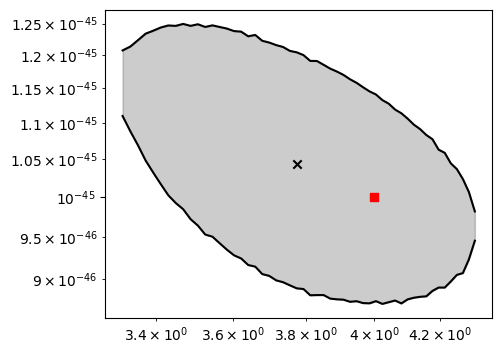

In [867]:
%%time
nr = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], 
        vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']),
        rhosun=p50(mwd['rhosuns']), Ethr=0.1, Eroi=5.0, ω=10.0)

mock = nr.mocksample(4., 1e-45, 0.001, Ntot='mean', seed=5100)
mle1 = MLE(mock, nr)
sol1 = mle1.get_limits()

fig,ax = plt.subplots(figsize=(5,4))
ax.plot(sol1[0], sol1[1], 'k-', sol1[0], sol1[2], 'k-')
ax.fill_between(*sol1, color='k', alpha=0.2)
ax.set_xscale('log')
ax.set_yscale('log')
ax.scatter(4., 1e-45, c='r', marker='s')
ax.scatter(mle1.mdm_min, mle1.sdm_min, c='k', marker='x')
plt.savefig('../Output/figures/nuclear/fig1.png', bbox_inches = 'tight', dpi=300)

In [ ]:
for gal in ['MW']+mwgals:
    chain_len = 
    mle = MLE(mock, nr_init, globalmin='precise', likelihood=2, 
              gal=gal, idx=ci)

In [605]:
Mgrid, Sgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)
Bgrid, Lgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)

for i,mdm in tqdm(enumerate(Mdm)):
    λsg_0 = nr.binTot(mdm, 1e-46, 0., mock['bin_edges'])['Neachbin']
    for j,sdm in enumerate(Sdm):
        λsg = λsg_0*sdm/1e-46
        blm = fsolve(bl̂_func, x0=0.001, args=(nobs, λsg, ΔE,
                     nr.exposure), full_output=1)
        Mgrid[i,j] = mdm
        Sgrid[i,j] = sdm
        Bgrid[i,j] = blm[0][0]
        Lgrid[i,j] = nlL1(blm[0][0], nobs, λsg, nr)

stat_res = {'Mgrid': Mgrid,
            'Sgrid': Sgrid,
            'Bgrid': Bgrid,
            'Lgrid': Lgrid,
            'indx': np.where(Lgrid == np.min(Lgrid)),
            'mdm_best': Mgrid[indx],
            'sdm_best': Sgrid[indx],
            'mdm_orig': 4.0,
            'sdm_orig': 1e-45,
            'll_min': np.min(Lgrid),
            'bl_min': Bgrid[indx], 
            'nr': nr,
            'mock': mock,
            'ΔE': ΔE,
            'Tgrid': 2*(Lgrid - np.min(Lgrid))}
# nrd['pfl']['nlL1'] = stat_res
# pickle.dump(nrd, open('../Output/Nuclear_dict.pkl','wb'))

0it [00:00, ?it/s]

### (ii) mass modelling RC uncertainity: $$\mathcal{L}_2^{(i)}(m, \sigma_p, b_l, \Theta_\mathrm{MW}) = \mathcal{L}_1(m,\, \sigma_p,\, b_l,\, \Theta^{(i)}_\mathrm{MW})\times \mathrm{P}(\Theta^{(i)}_\mathrm{MW}|D_\mathrm{MW}); \,\, \text{where, } \, i = 0, 1, ..., 7\, \text{and}, i = 0 \, \text{corresponds to the case of MW}$$

In [613]:
nr = Nr('Xe', vE=mwd['vE'], vdfE=mwd['vdfE_50'], 
        vesc=p50(mwd['vescs']), vcirc=p50(mwd['vcircs']),
        rhosun=p50(mwd['rhosuns']), Ethr=0.1, Eroi=5.0, ω=10.0)

mock = nr.mocksample(4., 1e-45, 0.001, Ntot='mean', seed=5100)
nobs = mock['binned_Esample']
ΔE = (nr.Eroi - nr.Ethr)/mock['Nbins']

def bl̂_func(bl, *args):
    nobs, λsg, ΔE, exp = args
    return np.mean(nobs/(λsg + exp*bl*ΔE)) - 1.0

def nlL2(bl, *args):
    nobs, λsg, ΔE, exp, idx, mwD = args
    λ = λsg + exp*ΔE*bl
    lL = np.sum(nobs*np.log(λ)) - np.sum(λ)
    lL += np.log(np.prod(mwD['par_pdfs'][idx]))
    return -lL

Ngrid = 100
Mdm = np.logspace(0,1,Ngrid)
Sdm = np.logspace(-46,-44,Ngrid)

In [618]:
class PLLrun:
    def __init__(self, gal):
        self.gal = gal
        if gal == 'MW':
            self.mwD = mwd
        elif gal in mwgals:
            self.mwD = mwld[gal]
        

    def func_pll(self, idx):
        nr_ = Nr('Xe', vE=self.mwD['vE'], vdfE=self.mwD['vdfEs'][idx],
                 vesc=self.mwD['vescs'][idx], vcirc=self.mwD['vcircs'][idx],
                 rhosun=self.mwD['rhosuns'][idx], Ethr=0.1, Eroi=5.0,
                 ω=10.0)
        Bgrid_idx = np.zeros([Ngrid]*2)
        Lgrid_idx = np.zeros([Ngrid]*2)
        for i,mdm in enumerate(Mdm):
            λsg_0 = nr_.binTot(mdm, 1e-46, 0., mock['bin_edges'])['Neachbin']
            for j,sdm in enumerate(Sdm):
                λsg = λsg_0*sdm/1e-46
                blm = fsolve(bl̂_func, 0.001, args=(nobs, λsg, ΔE, 
                                                 nr_.exposure))[0]
                Bgrid_idx[i,j] = blm
                args = (nobs, λsg, ΔE, nr_.exposure, idx, self.mwD)
                Lgrid_idx[i,j] = nlL2(blm, *args)
        return {'Bgrid_idx': Bgrid_idx,
                'Lgrid_idx': Lgrid_idx,
                'idx': idx}

    def parallel_process(self, Idx):
        num_cores = cpu_count()
        print (f'process running in {num_cores} cores (total iterations {len(Idx)}) for {self.gal}')
        with Pool(processes=num_cores) as pool:
            results = list(tqdm(pool.imap(self.func_pll, Idx), total=len(Idx)))
        return results

    def get_result(self, chain_len=None):
        if chain_len == None:
            chain_len = len(self.mwD['vdfEs'])
        self.results = self.parallel_process(np.arange(chain_len))

In [619]:
pll_dict = {}
for gal in tqdm(['MW']+mwgals):
    pll = PLLrun(gal)
    pll.get_result(chain_len = 4)
    pll_dict[gal] = pll.results

  0%|          | 0/8 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for MW


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for NGC4013


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for NGC4157


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for NGC4217


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for NGC5985


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for NGC7814


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for UGC03546


  0%|          | 0/4 [00:00<?, ?it/s]

process running in 8 cores (total iterations 4) for UGC05253


  0%|          | 0/4 [00:00<?, ?it/s]

In [620]:
pll_dict['MW']

[{'Bgrid_idx': array([[0.0010449 , 0.0010449 , 0.0010449 , ..., 0.0010449 , 0.0010449 ,
          0.0010449 ],
         [0.0010449 , 0.0010449 , 0.0010449 , ..., 0.0010449 , 0.0010449 ,
          0.0010449 ],
         [0.0010449 , 0.0010449 , 0.0010449 , ..., 0.0010449 , 0.0010449 ,
          0.0010449 ],
         ...,
         [0.0010315 , 0.00103087, 0.00103022, ..., 0.00052659, 0.00051537,
          0.00050411],
         [0.00103134, 0.00103071, 0.00103004, ..., 0.00050479, 0.00049279,
          0.00048074],
         [0.00103117, 0.00103053, 0.00102985, ..., 0.00048177, 0.00046893,
          0.00045602]]),
  'Lgrid_idx': array([[-92003.85659062, -92003.85659062, -92003.85659062, ...,
          -92003.85659062, -92003.85659062, -92003.85659062],
         [-92003.85659062, -92003.85659062, -92003.85659062, ...,
          -92003.85659062, -92003.85659062, -92003.85659062],
         [-92003.85659062, -92003.85659062, -92003.85659062, ...,
          -92003.85659062, -92003.85659062, -920

In [567]:
Mgrid, Sgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)
Bgrid, Lgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)

nll2d = {}
pll_results = nrd['pfl']['pll_results']
for i,gal in tqdm(enumerate(['MW']+mwgals)):
    pll_res = pll_results[gal]
    for i,mdm in enumerate(Mdm):
        for j,sdm in enumerate(Sdm):
            Larray = np.zeros(len(pll_res))
            Barray = np.zeros(len(pll_res))
            for k,res in enumerate(pll_res):
                Larray[k] = res['Lgrid_idx'][i,j]
                Barray[k] = res['Bgrid_idx'][i,j]
            Larray[np.isnan(Larray)] = 1e32
            Lgrid[i,j] = np.min(Larray)
            Bgrid[i,j] = Barray[Larray == np.min(Larray)][0]
            Mgrid[i,j] = Mdm[i]
            Sgrid[i,j] = Sdm[j]

    indx = np.where(Lgrid == np.min(Lgrid))
    nll2d[gal] = {'Mgrid': Mgrid,
                  'Sgrid': Sgrid,
                  'Bgrid': Bgrid,
                  'Lgrid': Lgrid,
                  'indx': indx,
                  'mdm_best': Mgrid[indx],
                  'sdm_best': Sgrid[indx],
                  'mdm_orig': 4.0,
                  'sdm_orig': 1e-45,
                  'll_min': np.min(Lgrid),
                  'bl_min': Bgrid[indx], 
                  'nr': nr,
                  'mock': mock,
                  'ΔE': ΔE,
                  'Tgrid': 2*(Lgrid - np.min(Lgrid))}
nrd['pfl']['nlL2'] = nll2d

0it [00:00, ?it/s]

### (iii) intrinsic uncertainity: $$\mathcal{L}_3$$

In [575]:
ultrares = MW_dict['ultraresults']
mw_means = ultrares['posterior']['mean']
mw_stdev = ultrares['posterior']['stdev']
χd = {'MW': 0}
for gal in mwgals:
    m200,c200,mdstar,mdbul,mdgas,rdstar,rdbul,rdgas = mw_means
    em200,ec200,emdstar,emdbul,emdgas,erdstar,erdbul,erdgas = mw_stdev
    gald = sparcd[gal]['cusp_fit']
    gm200 = 10**(gald['lm'][0]-12.)
    gc200 = gald['c200'][0]
    gmdstar = 10**(gald['lmstar'][0]-9.)
    gmdbul = 10**(gald['lmbul'][0]-9.)
    gmdgas = 10**(gald['lmgas'][0]-9.)
    grdstar = gald['rdstar'][0]
    grdbul = gald['rdbul'][0]
    grdgas = gald['rdgas'][0]
    χ = ((m200-gm200)/(em200))**2 + ((c200-gc200)/ec200)**2
    χ += ((mdstar-gmdstar)/emdstar)**2 + ((rdstar-grdstar)/erdstar)**2
    χ += ((mdgas-gmdgas)/emdgas)**2 + ((rdgas-grdgas)/erdgas)**2
    χ += ((mdbul-gmdbul)/emdbul)**2 + ((rdbul-grdbul)/erdbul)**2
    χd[gal] = χ

In [576]:
Mgrid, Sgrid, Lgrid = np.zeros([Ngrid]*2), np.zeros([Ngrid]*2), np.zeros([Ngrid]*2)

pll_results = nrd['pfl']['pll_results']
for mi,mdm in tqdm(enumerate(Mdm)):
    for si,sdm in enumerate(Sdm):
        Nll = []
        for gal in ['MW']+mwgals:
            pll_res = pll_results[gal]
            for ci in range(len(pll_res)):
                nll = pll_res[ci]['Lgrid_idx'][mi,si]
                nll += 0 #-χd[gal]/2.
                Nll.append(nll)
        Nll = np.array(Nll)
        Nll[np.isnan(Nll)] = 1e32
        Lgrid[mi,si] = np.min(Nll)
        Mgrid[mi,si] = mdm
        Sgrid[mi,si] = sdm

indx = np.where(Lgrid == np.min(Lgrid))
nlL3_dict = {'Mgrid': Mgrid,
             'Sgrid': Sgrid,
             'Bgrid': Bgrid,
             'Lgrid': Lgrid,
             'indx': indx,
             'mdm_best': Mgrid[indx],
             'sdm_best': Sgrid[indx],
             'mdm_orig': 4.0,
             'sdm_orig': 1e-45,
             'll_min': np.min(Lgrid),
             'Tgrid': 2*(Lgrid - np.min(Lgrid)),
             'χd':χd}
nrd['pfl']['nlL3'] = nlL3_dict

0it [00:00, ?it/s]

# 2. plotting

In [599]:
pll_res = pll_results['MW']

In [602]:
pll_res[0]['Lgrid_idx']

array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])

[[1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]
 [1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]
 [1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]
 ...
 [1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]
 [1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]
 [1.e+32 1.e+32 1.e+32 ... 1.e+32 1.e+32 1.e+32]]


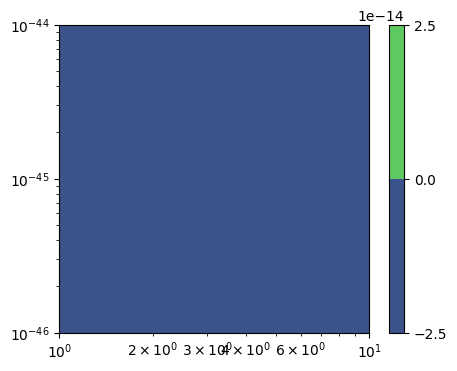

In [598]:
fig,ax = plt.subplots(figsize = (5,4))

nrD = nrd['pfl']['nlL1']
ax.contourf(nrD['Mgrid'], nrD['Sgrid'], nrD['Tgrid'], levels=[0,5.99])
nrD = nrd['pfl']['nlL2']['MW']
cn = ax.contourf(nrD['Mgrid'], nrD['Sgrid'], nrD['Tgrid'])
cb = fig.colorbar(cn)
print (nrD['Lgrid'])
ax.set_xscale('log')
ax.set_yscale('log')

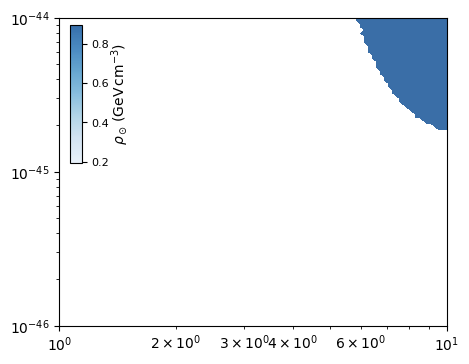

In [591]:
fig, ax = plt.subplots(figsize=(5,4))

tclrs = pa.truncate_colormap(plt.get_cmap('Blues'),0.1,0.9)
rhosuns = []
for gal in ['MW']+mwgals:
    mwD = mwd if gal == 'MW' else mwld[gal]
    rhosun = p50(mwD['rhosuns'])
    rhosuns.append(rhosun)
rhosuns = np.array(rhosuns)
normalized_rhosuns = rhosuns/np.max(rhosuns)
clrs = tclrs(normalized_rhosuns)

for gi,gal in enumerate(['MW']+mwgals):
    if gal == 'MW':
        continue
    if gal in mwgals[:3]:
        continue
    nrD = nrd['pfl']['nlL2'][gal]
    ax.contourf(nrD['Mgrid'], nrD['Sgrid'], nrD['Tgrid'], [0,5.99],
                colors=[clrs[gi]], alpha=0.8, zorder=1.)
    break

sc = ax.scatter([0]*8, [0]*8, c=rhosuns, cmap=tclrs, alpha=0.8, vmax=rhosuns.max())
cax = inset_axes(ax, width="3%", height="45%", loc='upper left',bbox_to_anchor=[0.01,0,1,1], bbox_transform=ax.transAxes)
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label(r'$\rho_\odot\, (\mathrm{GeV\, cm^{-3}})$', labelpad=0)
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8], labels=[0.2,0.4,0.6,0.8], size=8)

ax.set_xscale('log')
ax.set_yscale('log')

In [446]:
def plot_CL(nrd, keys = [], gals = [], Mgrids = [], Sgrids = [],
            Tgrids = [], fig=None, ax=None, labels=['stat'],
            clrs=[], alpha=0.4, zorder=1):
    if (not ax):
        fig,ax = plt.subplots(figsize=(5,4))

    Mgrids, Sgrids, Tgrids = [], [], []
    
    if len(keys) != 0:
        for key in keys:
            if key == 'stat':
                Mgrids.append(nrd['pfl'][key]['Mgrid'])
                Sgrids.append(nrd['pfl'][key]['Sgrid'])
                Tgrids.append(nrd['pfl'][key]['Tgrid'])
            elif key == 'MW':
                Mgrids.append(nrd['pfl'][key]['nlL2']['Mgrid'])
                Sgrids.append(nrd['pfl'][key]['nlL2']['Sgrid'])
                Tgrids.append(nrd['pfl'][key]['nlL2']['Tgrid'])
            elif key == 'MWlike':
                Mgrids.append(nrd['pfl'][key]['nlL3']['Mgrid'])
                Sgrids.append(nrd['pfl'][key]['nlL3']['Sgrid'])
                Tgrids.append(nrd['pfl'][key]['nlL3']['Tgrid'])
    if len(gals) != 0:
        for gal in gals:
            nrd_ = nrd['pfl']['MWlike']['nlL2'][gal]
            Mgrids.append(nrd_['Mgrid'])
            Sgrids.append(nrd_['Sgrid'])
            Tgrids.append(nrd_['Tgrid'])

    if len(clrs) == 0:
        clrs = plt.rcParams['axes.prop_cycle'].by_key()['color'][:len(Mgrids)]
        
    for i in range(len(Mgrids)):
        ax.contourf(Mgrids[i], Sgrids[i], Tgrids[i], [0, 5.99], 
                    colors=[clrs[i]], alpha=alpha, 
                    zorder=zorder)
        ax.contour(Mgrids[i], Sgrids[i], Tgrids[i], [0., 5.99],
                   colors=[clrs[i]], alpha=alpha,
                   zorder=zorder)

    # ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xticks([1,2,3,4,5,6,7,8,9,10],
                  [1,2,3,4,5,6,7,8,9,10])
    ax.set_xlabel('$m$ (GeV)')
    ax.set_ylabel('$\sigma_p \, (\mathrm{cm}^2)$')

    ax.set_xlim(1.8,5.2)
    ax.set_ylim(1e-46, 1e-44)

    return fig,ax

KeyError: 'NGC4013'

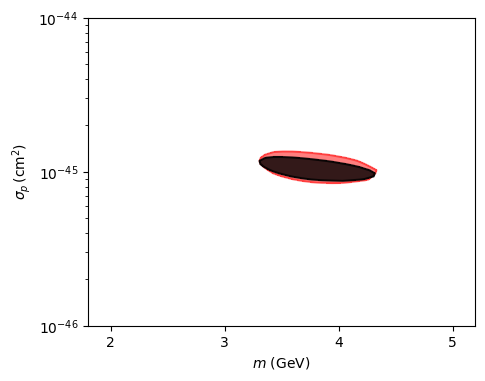

In [447]:
import project.plot_assist as pa
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

fig,ax = plt.subplots(figsize=(5,4))

fig,ax = plot_CL(nrd, keys=['stat'], alpha=0.8,
                 ax=ax, fig=fig, clrs=['k'], zorder=3)
fig,ax = plot_CL(nrd, keys=['MW'], alpha=0.5,
                 zorder=2, ax=ax, fig=fig, clrs=['r'])

tclrs = pa.truncate_colormap(plt.get_cmap('Blues'),0.1,0.9)
rhosuns = []
for i,gal in enumerate(mwgals):
    rhosun = p50(mwld[gal]['rhosuns'])
    rhosuns.append(rhosun)
rhosuns = np.array(rhosuns)
rhosunsnorm = rhosuns/np.max(rhosuns)
clrs = tclrs(rhosunsnorm)

fig,ax = plot_CL(nrd, gals=mwgals, alpha=0.8,
                 zorder=1, ax=ax, fig=fig, clrs=clrs)

sc = ax.scatter([0]*7, [0]*7, c=rhosuns, cmap=tclrs, alpha=0.8, vmax=rhosuns.max())
cax = inset_axes(ax, width="3%", height="45%", loc='upper left',bbox_to_anchor=[0.01,0,1,1], bbox_transform=ax.transAxes)
cbar = plt.colorbar(sc, cax=cax)
cbar.set_label(r'$\rho_\odot\, (\mathrm{GeV\, cm^{-3}})$', labelpad=0)
cbar.set_ticks(ticks=[0.2,0.4,0.6,0.8], labels=[0.2,0.4,0.6,0.8], size=8)

ax.fill_between([0]*2, [0]*2, [0]*2, color='k', alpha=0.8, label='$\Delta m_\mathrm{stat}$')
ax.fill_between([0]*2, [0]*2, [0]*2, color='r', alpha=0.5, label='$\Delta m_\mathrm{stat} + \Delta m_\mathrm{MW}$')
ax.fill_between([0]*2, [0]*2, [0]*2, color=tclrs(0.5), alpha=0.5, label='$\Delta m_\mathrm{stat} + \Delta m_\mathrm{MW-like}$')
ax.legend(frameon=False, prop={'size':9}, loc='upper right');

# plt.savefig('../Output/figures/nuclear/test_stat_blMWL.png',bbox_inches = 'tight', dpi=300)